In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc

from src.ensemble import get_de_preds, get_le_preds
from src.metrics import dice_coef, dice_norm_metric, soft_dice_norm_metric, rc_curve
from src.uncertainty import (entropy_of_expected_uncertainty, expected_entropy_uncertainty,
                             mutual_information_uncertainty, reverse_mutual_information_uncertainty,
                             expected_pw_kl_uncertainty, max_prob_uncertainty,
                             naive_pred_size_uncertainty)

# Validation

## Layer Ensemble

In [3]:
le_validation_fpath = Path('models')/'LE_validation.npz'

le_preds, targets = get_le_preds(le_validation_fpath)
le_preds = le_preds['le_mean_starting_at_05']

le_ndsc_scores = list()
for pred, target in zip(le_preds, targets):
    le_ndsc_scores.append(dice_norm_metric(pred, target))
le_ndsc_scores = np.array(le_ndsc_scores)

In [4]:
def plot_auc_over_starting_layer(uncertainties, scores, metrics,
                                 title='AUC over Starting Layer'):
    aucs = dict()
    for metric_name in metrics.keys():
        metric_aucs = list()
        unc_names = sorted([m for m in uncertainties.keys()
                            if m.startswith(metric_name)])
        for unc_name in unc_names:
            coverages, risks, _ = rc_curve(-uncertainties[unc_name],
                                           scores, expert=False)
            metric_aucs.append(auc(coverages, risks))

        plt.plot(metric_aucs, label=f"{metric_name} ({min(metric_aucs):.3f}@{np.argmin(metric_aucs)})")

        aucs[metric_name] = metric_aucs

    # ideal uncertainty estimation
    coverages, risks, _ = rc_curve(scores, scores, expert=False)
    ideal_auc = auc(coverages, risks)

    # naive (random) uncertainty estimation
    naive_risks = np.zeros(scores.shape)
    n_random = 10
    for _ in range(n_random):
        coverages, risks, _ = rc_curve(np.random.rand(*scores.shape),
                                       scores, expert=False)
        naive_risks += risks / n_random
    naive_auc = auc(coverages, naive_risks)

    plt.hlines(ideal_auc, 0, 10, color='blue', linestyle='--', label=f'ideal ({ideal_auc:.3f})')
    plt.hlines(naive_auc, 0, 10, color='red', linestyle='--', label=f'random ({naive_auc:.3f})')

    plt.title(title)
    plt.ylabel('AUC of Risk-Coverage (no expert)')
    plt.xlabel('starting layer')
    plt.legend()
    plt.grid()

    return aucs

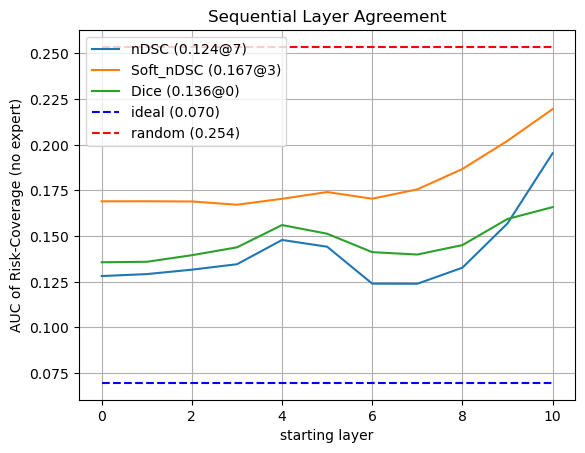

In [5]:
def apply_layer_agreement_metric(Y_hat, metric):
    uncertainties = list()
    for y_hat in Y_hat.swapaxes(0,1):
        uncertainty = [metric(y_hat[i], y_hat[i+1])
                       for i in range(y_hat.shape[0]-1)]
        uncertainties.append(sum(uncertainty) / len(uncertainty))
    
    return np.array(uncertainties)

agreement_metrics = {'nDSC': lambda *args: -dice_norm_metric(*args),
                     'Soft_nDSC': lambda *args: -soft_dice_norm_metric(*args),
                     'Dice': lambda *args: -dice_coef(*args),}

layer_agreement_uncertainties = dict()
with np.load(le_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for i in range(Y_hat.shape[0]-1):
        components = Y_hat[i:]
        for metric_name, metric in agreement_metrics.items():
            layer_agreement_uncertainties[metric_name+f'@le_from_{i:02d}'] = (
                apply_layer_agreement_metric(components, metric)
            )

plot_auc_over_starting_layer(layer_agreement_uncertainties, le_ndsc_scores,
                             agreement_metrics, title='Sequential Layer Agreement')
plt.show()

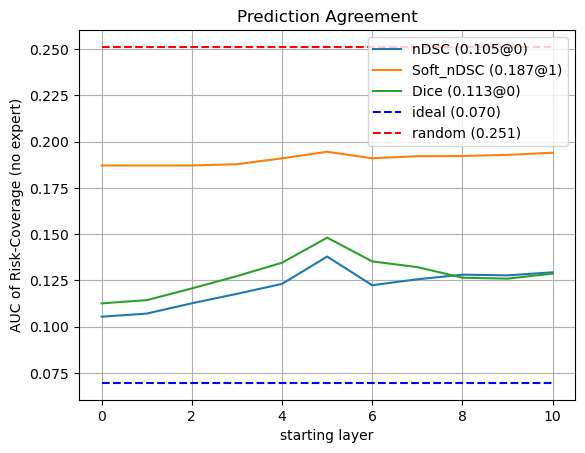

In [162]:
def apply_pred_agreement_metric(Y_hat, preds, metric):
    uncertainties = list()
    for y_hat, pred in zip(Y_hat.swapaxes(0,1), preds):
        uncertainty = [metric(y_hat[i], pred) for i in range(y_hat.shape[0]-1)]
        uncertainties.append(sum(uncertainty) / len(uncertainty))
    return np.array(uncertainties)

agreement_metrics = {'nDSC': lambda *args: -dice_norm_metric(*args),
                     'Soft_nDSC': lambda *args: -soft_dice_norm_metric(*args),
                     'Dice': lambda *args: -dice_coef(*args),}

pred_agreement_uncertainties = dict()
with np.load(le_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for i in range(Y_hat.shape[0]-1):
        components = Y_hat[i:]
        for metric_name, metric in agreement_metrics.items():
            pred_agreement_uncertainties[metric_name+f'@le_from_{i:02d}'] = (
                apply_pred_agreement_metric(components, le_preds, metric)
            )

plot_auc_over_starting_layer(pred_agreement_uncertainties, le_ndsc_scores,
                             agreement_metrics, title='Prediction Agreement')
plt.show()

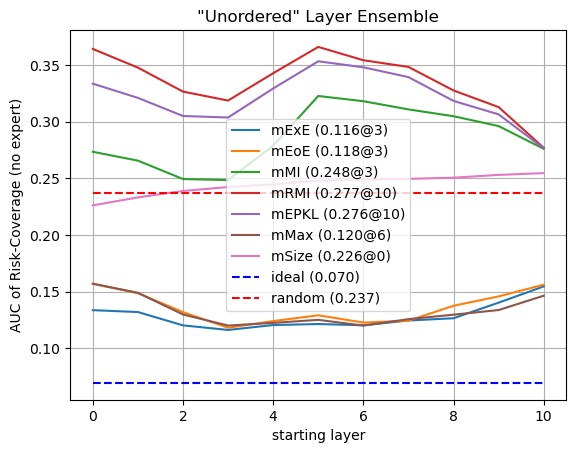

In [7]:
def apply_ensemble_metric(Y_hat, metric):
    uncertainties = list()
    for y_hat in Y_hat.swapaxes(0,1):
        uncertainties.append(metric(y_hat))
    
    return np.array(uncertainties)

ensemble_metrics = {'mExE': expected_entropy_uncertainty,
                    'mEoE': entropy_of_expected_uncertainty,
                    'mMI': mutual_information_uncertainty,
                    'mRMI': reverse_mutual_information_uncertainty,
                    'mEPKL': expected_pw_kl_uncertainty,
                    'mMax': max_prob_uncertainty,
                    'mSize': naive_pred_size_uncertainty,
                    }

le_ensemble_uncertainties = dict()
with np.load(le_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for i in range(Y_hat.shape[0]-1):
        components = Y_hat[i:]
        for metric_name, metric in ensemble_metrics.items():
            le_ensemble_uncertainties[metric_name+f'@le_from_{i:02d}'] = (
                apply_ensemble_metric(components, metric)
            )

plot_auc_over_starting_layer(le_ensemble_uncertainties, le_ndsc_scores,
                             ensemble_metrics, title='"Unordered" Layer Ensemble')
plt.show()

## Deep Ensemble

In [8]:
de_validation_fpath = Path('models')/'DE_validation.npz'

de_preds, targets = get_de_preds(de_validation_fpath)
de_preds = de_preds['mean_ensemble']

de_ndsc_scores = list()
for pred, target in zip(de_preds, targets):
    de_ndsc_scores.append(dice_norm_metric(pred, target))
de_ndsc_scores = np.array(de_ndsc_scores)

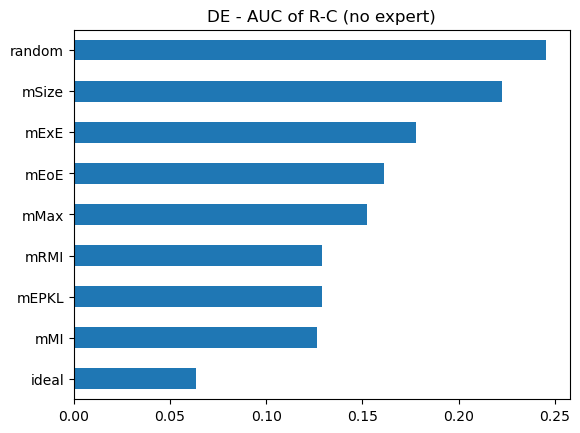

random    0.245421
mSize     0.222652
mExE      0.177672
mEoE      0.161352
mMax      0.152451
mRMI      0.129067
mEPKL     0.128937
mMI       0.126473
ideal     0.063635
dtype: float64

In [9]:
ensemble_metrics = {'mExE': expected_entropy_uncertainty,
                    'mEoE': entropy_of_expected_uncertainty,
                    'mMI': mutual_information_uncertainty,
                    'mRMI': reverse_mutual_information_uncertainty,
                    'mEPKL': expected_pw_kl_uncertainty,
                    'mMax': max_prob_uncertainty,
                    'mSize': naive_pred_size_uncertainty,}

de_uncertainties = dict()
de_aucs = dict()
with np.load(de_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for metric_name, metric in ensemble_metrics.items():
        uncertainties = apply_ensemble_metric(Y_hat, metric)
        de_uncertainties[metric_name] = uncertainties

        coverages, risks, _ = rc_curve(-uncertainties, de_ndsc_scores,
                                       expert=False)
        de_aucs[metric_name] = auc(coverages, risks)

# ideal uncertainty estimation
coverages, risks, _ = rc_curve(de_ndsc_scores, de_ndsc_scores,
                                expert=False)
de_aucs['ideal'] = auc(coverages, risks)

# naive (random) uncertainty estimation
naive_risks = np.zeros(de_ndsc_scores.shape)
n_random = 10
for _ in range(n_random):
    coverages, risks, _ = rc_curve(np.random.rand(*de_ndsc_scores.shape),
                                de_ndsc_scores, expert=False)
    naive_risks += risks / n_random
de_aucs['random'] = auc(coverages, naive_risks)

aucs = pd.Series(de_aucs).sort_values()
aucs.plot.barh()
plt.title("DE - AUC of R-C (no expert)")
plt.show()
aucs.sort_values(ascending=False)

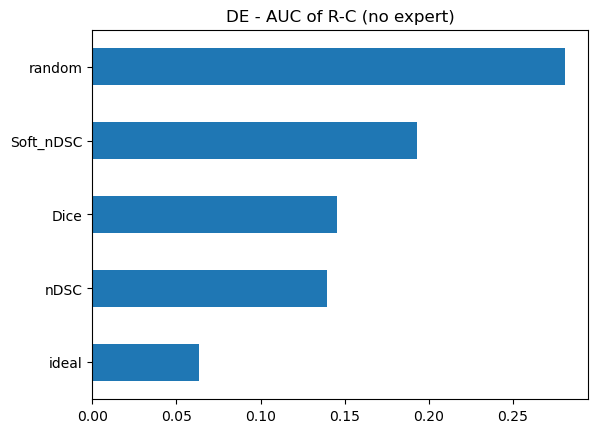

random       0.280645
Soft_nDSC    0.192957
Dice         0.145377
nDSC         0.139307
ideal        0.063635
dtype: float64

In [181]:
agreement_metrics = {'nDSC': lambda *args: -dice_norm_metric(*args),
                     'Soft_nDSC': lambda *args: -soft_dice_norm_metric(*args),
                     'Dice': lambda *args: -dice_coef(*args),}

de_pred_uncertainties = dict()
de_pred_aucs = dict()
with np.load(de_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for metric_name, metric in agreement_metrics.items():
        uncertainties = apply_pred_agreement_metric(Y_hat, de_preds, metric)
        de_pred_uncertainties[metric_name] = uncertainties

        coverages, risks, _ = rc_curve(-uncertainties, de_ndsc_scores,
                                       expert=False)
        de_pred_aucs[metric_name] = auc(coverages, risks)

# ideal uncertainty estimation
coverages, risks, _ = rc_curve(de_ndsc_scores, de_ndsc_scores,
                                expert=False)
de_pred_aucs['ideal'] = auc(coverages, risks)

# naive (random) uncertainty estimation
naive_risks = np.zeros(de_ndsc_scores.shape)
n_random = 10
for _ in range(n_random):
    coverages, risks, _ = rc_curve(np.random.rand(*de_ndsc_scores.shape),
                                de_ndsc_scores, expert=False)
    naive_risks += risks / n_random
de_pred_aucs['random'] = auc(coverages, naive_risks)

pred_aucs = pd.Series(de_pred_aucs).sort_values()
pred_aucs.plot.barh()
plt.title("DE - AUC of R-C (no expert)")
plt.show()
pred_aucs.sort_values(ascending=False)